# AIR QUALITY

0 Date (DD/MM/YYYY)

1 Time (HH.MM.SS)

12 Temperature in C

13 Relative Humidity

14 AH Absolute Humidity

In [1]:
import os
import numpy
import pandas
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow
from tensorflow import keras

random_seed = 32
numpy.random.seed(random_seed)
tensorflow.random.set_seed(random_seed)
keras.utils.set_random_seed(random_seed)
tensorflow.config.experimental.enable_op_determinism()

In [2]:
# TRAINING
n_test_samples = 8
n_validation_samples = 28

# # DECLARE NET
n_steps = 2
batch_size = 60
x_cols = ['T','AH', 'RH']

y_cols = ['T_d1']
Y_name = 'T_d1'
memory_units = 2
hidden_1_units = 3
hidden_2_units = 2
hidden_activation = 'tanh'
patience = 250
learning_rate = 0.001
max_epochs = 10*patience
error_bar = 3.0

n_features = len(x_cols)

In [3]:
working_dir = os.getcwd()
notebooks_dir = os.path.dirname(working_dir)
root_dir = os.path.dirname(notebooks_dir)
data_dir = os.path.join(root_dir, 'datasets')
air_quality_file = os.path.join(data_dir, 'air_quality.csv')
df = pandas.read_csv(air_quality_file, sep=';', decimal=',')

df['Date'] = pandas.to_datetime(df['Date'], format='%d/%m/%Y')
df.loc[df['T'] == -200, 'T'] = numpy.nan
df.loc[df['RH'] < 0.0, 'RH'] = numpy.nan
df.loc[df['AH'] < 0.0, 'AH'] = numpy.nan
df_day = df[['Date', 'T', 'RH', 'AH']].groupby('Date').mean()

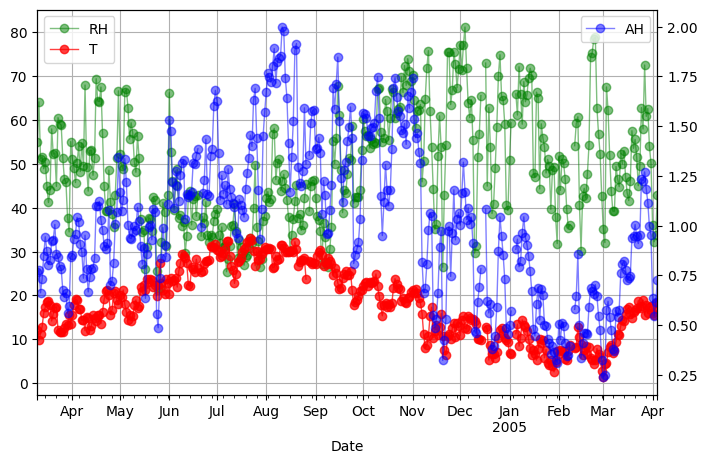

In [4]:
fig = pyplot.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
_ = df_day.plot(y='AH', ax=ax2, lw=1, marker='o', color='blue', alpha=0.5)
_ = df_day.plot(y='RH', ax=ax, lw=1, marker='o', color='green', alpha=0.5)
_ = df_day.plot(y='T', ax=ax, lw=1, marker='o', color='red', alpha=0.75)
_ = ax.grid()

In [5]:
df_day['T_d1'] = df_day['T'].shift(-1)
complete_cases = ~df_day.isna().any(axis=1)
df_day = df_day[complete_cases].copy()

In [6]:
df_day

,T,RH,AH,T_d1
Date,,,,
2004-03-10,12.033333,54.900000,0.765633,9.837500
2004-03-11,9.837500,64.075000,0.775767,11.287500
2004-03-12,11.287500,51.095833,0.663104,12.866667
2004-03-13,12.866667,51.533333,0.732296,16.012500
2004-03-14,16.012500,48.850000,0.849671,17.366667
...,...,...,...,...
2005-03-30,17.433333,54.037500,0.996762,17.550000
2005-03-31,17.550000,50.083333,0.951917,15.929167
2005-04-01,15.929167,35.962500,0.636529,15.483333


In [7]:
# SAMPLING
X_trn = df_day.iloc[:-(n_validation_samples + n_test_samples)][x_cols].to_numpy()
X_val = df_day.iloc[-(n_validation_samples + n_test_samples):-n_test_samples][x_cols].to_numpy()
X_tst = df_day[x_cols].to_numpy()
Y_trn = df_day.iloc[:-(n_validation_samples + n_test_samples)][y_cols].to_numpy()
Y_val = df_day.iloc[-(n_validation_samples + n_test_samples):-n_test_samples][y_cols].to_numpy()
Y_tst = df_day[y_cols].to_numpy()

# SCALING X
X_scaler = StandardScaler()
X_scaler = X_scaler.fit(X_trn)
X_trn_scaled = X_scaler.transform(X_trn)
X_val_scaled = X_scaler.transform(X_val)
X_tst_scaled = X_scaler.transform(X_tst)

# SCALING Y
Y_scaler = StandardScaler()
Y_scaler = Y_scaler.fit(Y_trn)
Y_trn_scaled = Y_scaler.transform(Y_trn)
Y_val_scaled = Y_scaler.transform(Y_val)
Y_tst_scaled = Y_scaler.transform(Y_tst)

# SEQUENCES
X_trn_seq = keras.utils.timeseries_dataset_from_array(X_trn_scaled, Y_trn_scaled, sequence_length=n_steps, sampling_rate=1, batch_size=batch_size)
X_val_seq = keras.utils.timeseries_dataset_from_array(X_val_scaled, Y_val_scaled, sequence_length=n_steps, sampling_rate=1, batch_size=batch_size)
X_tst_seq = keras.utils.timeseries_dataset_from_array(X_tst_scaled, Y_tst_scaled, sequence_length=n_steps, sampling_rate=1, batch_size=batch_size)

In [8]:
# DECLARE NET 99.8% 4 / 3 / 2
# inputs = tensorflow.keras.Input(shape=(n_steps, n_features)) # time steps, features
# lstm = keras.layers.LSTM(memory_units, activation='tanh', return_sequences=False)(inputs)
# hidden_1 = keras.layers.Dense(hidden_1_units, activation=hidden_activation)(lstm)
# hidden_2 = keras.layers.Dense(hidden_2_units, activation=hidden_activation)(hidden_1)
# outputs = keras.layers.Dense(1)(hidden_2)
# model_name = 'air_quality_lstm'
# network = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
# optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# network.compile(optimizer=optimizer, loss='mse', metrics='mse')
# network.summary()

In [10]:
# DECLARE NET (AUTOENCODING) 2 / 1 / 2 99.8%
inputs = tensorflow.keras.Input(shape=(n_steps, n_features)) # time steps, features
hidden_1 = keras.layers.Dense(hidden_1_units, activation=hidden_activation)(inputs)
lstm = keras.layers.LSTM(memory_units, activation='tanh', return_sequences=False)(hidden_1)
hidden_2 = keras.layers.Dense(hidden_2_units, activation=hidden_activation)(lstm)
outputs = keras.layers.Dense(1)(hidden_2)
model_name = 'air_quality_lstm_autoencoding'
network = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
network.compile(optimizer=optimizer, loss='mse')
network.summary()

Model: "air_quality_lstm_autoencoding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2, 3)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2, 2)           │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
# FIT THIS BABY
es_val_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
history = network.fit(X_trn_seq, epochs=max_epochs, validation_data=X_val_seq, batch_size=batch_size, callbacks=[es_val_callback])

Epoch 1/2500
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.8105 - val_loss: 1.2162
Epoch 2/2500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7990 - val_loss: 1.2027
Epoch 3/2500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7905 - val_loss: 1.1886
Epoch 4/2500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7828 - val_loss: 1.1746
Epoch 5/2500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7755 - val_loss: 1.1611
Epoch 6/2500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7686 - val_loss: 1.1481
Epoch 7/2500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7620 - val_loss: 1.1354
Epoch 8/2500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7555 - val_loss: 1.1230
Epoch 9/2500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7490 - val_loss: 1.1107
Epoch 10/2500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7425 - val_loss: 1.0982
Epoch 11/2500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7359 - val_loss: 1.0854
Epoch 12/2500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7289 - va

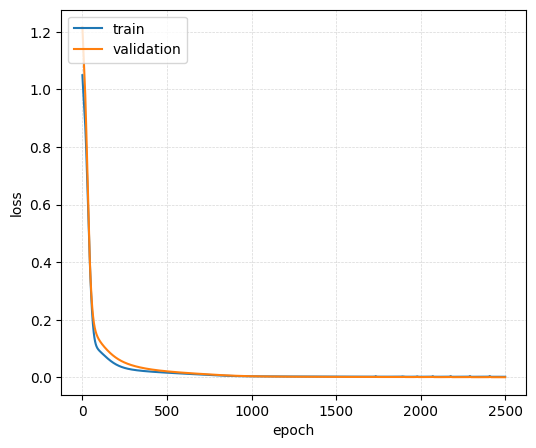

In [13]:
# plot history
fig = pyplot.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
_ = ax.plot(history.history['loss'], label='train')
_ = ax.plot(history.history['val_loss'], label='validation')
_ = ax.set_xlabel('epoch')
_ = ax.set_ylabel('loss')
_ = ax2.set_ylabel('mse')
_ = ax.legend(loc='upper left')
_ = ax.grid(ls='--', lw=0.5, alpha=0.5)


In [14]:
Y_est_scaled = network.predict(X_tst_seq, verbose=0)
Y_est = Y_scaler.inverse_transform(Y_est_scaled)
df_day['Y_est'] = numpy.nan
df_day.iloc[:-(n_steps-1), df_day.columns.get_loc("Y_est")] = Y_est
complete_cases = ~df_day.isna().any(axis=1)
results = df_day[complete_cases].copy()

results['residual'] = results['Y_est'] - results['T_d1']
best_std_residual = results.residual.std()
results['rabs'] = results['residual'].abs()
results['upper_bound'] = results['Y_est'] + error_bar*best_std_residual
results['lower_bound'] = results['Y_est'] - error_bar*best_std_residual
results['goal'] = ((results[Y_name] >= results['lower_bound']) & (results[Y_name] <= results['upper_bound'])).astype(int)
model_r2_score = r2_score(results[Y_name].to_numpy(), results["Y_est"].to_numpy())

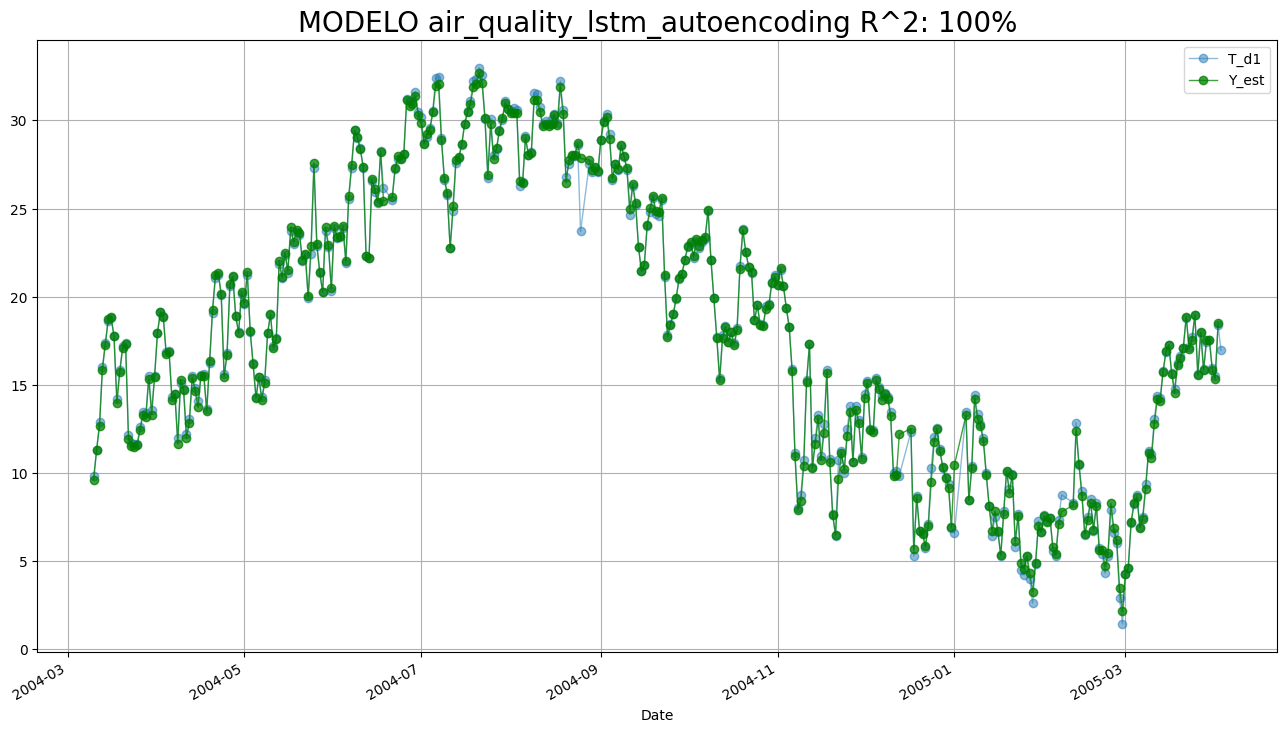

In [15]:
fig = pyplot.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
_ = df_day.plot(y='T_d1', ax=ax, lw=1, marker='o', alpha=0.5)
_ = df_day.plot(y='Y_est', ax=ax, lw=1, marker='o', alpha=0.75, color='green')
_ = ax.grid()
_ = ax.set_title('MODELO {} R^2: {:.0f}%'.format(model_name, 100.0*model_r2_score), size=20)

In [16]:
results

,T,RH,AH,T_d1,Y_est,residual,rabs,upper_bound,lower_bound,goal
Date,,,,,,,,,,
2004-03-10,12.033333,54.900000,0.765633,9.837500,9.615204,-0.222296,0.222296,10.730084,8.500324,1
2004-03-11,9.837500,64.075000,0.775767,11.287500,11.316150,0.028650,0.028650,12.431030,10.201270,1
2004-03-12,11.287500,51.095833,0.663104,12.866667,12.651039,-0.215628,0.215628,13.765919,11.536159,1
2004-03-13,12.866667,51.533333,0.732296,16.012500,15.864540,-0.147960,0.147960,16.979420,14.749660,1
2004-03-14,16.012500,48.850000,0.849671,17.366667,17.283571,-0.083095,0.083095,18.398451,16.168691,1
...,...,...,...,...,...,...,...,...,...,...
2005-03-29,15.916667,62.537500,1.116463,17.433333,17.528072,0.094739,0.094739,18.642952,16.413192,1
2005-03-30,17.433333,54.037500,0.996762,17.550000,17.533646,-0.016354,0.016354,18.648526,16.418766,1
2005-03-31,17.550000,50.083333,0.951917,15.929167,15.822906,-0.106261,0.106261,16.937786,14.708025,1


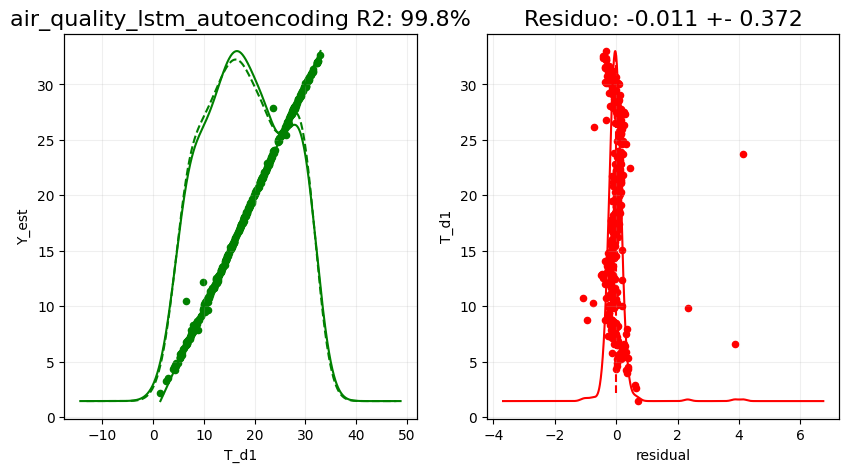

In [17]:
# STABLE RESIDUAL PLOT
r_mean = results.residual.mean()
r_std = results.residual.std()
r2 = r2_score(results[Y_name].to_numpy(), results['Y_est'].to_numpy())

fig = pyplot.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
_ = results.plot.scatter(x="T_d1", y='Y_est', ax=ax, color='green')
_ = ax.plot([results[Y_name].min(), results[Y_name].max()], [results[Y_name].min(), results[Y_name].max()], color='green')
_ = ax.grid(alpha=0.2)
_ = ax.set_title('{} R2: {:.1f}%'.format(model_name,100.0*r2), size=16)
ax2 = ax.twinx()
_ = results.T_d1.plot.kde(ax=ax2, color='green', label="T_d1")
_ = results.Y_est.plot.kde(ax=ax2, color='green', ls='--', label="Y_est")
_ = ax2.set_ylabel('')
_ = ax2.set_yticks([])
ax3 = fig.add_subplot(122)
_ = results.plot.scatter(x="residual", y='T_d1', ax=ax3, color='red')
ax4 = ax3.twinx()
_ = results.residual.plot.kde(ax=ax4, color='red', label="T_d1")
_ = ax3.grid(alpha=0.2)
_ = ax4.set_ylabel('')
_ = ax4.set_yticks([])
_ = ax4.set_title(f'Residuo: {r_mean:.3f} +- {r_std:.3f}', size=16)
_ = ax3.plot([r_mean, r_mean], [results.Y_est.min(), results.Y_est.max()], '--', color='red')

In [18]:
results.iloc[-n_test_samples:, :][[Y_name, 'lower_bound', 'Y_est', 'upper_bound', 'residual', 'rabs', 'goal']]

,T_d1,lower_bound,Y_est,upper_bound,residual,rabs,goal
Date,,,,,,,
2005-03-26,15.612500,14.437831,15.552711,16.667592,-0.059789,0.059789,1
2005-03-27,17.933333,16.876108,17.990988,19.105868,0.057654,0.057654,1
2005-03-28,15.916667,14.712775,15.827655,16.942535,-0.089012,0.089012,1
2005-03-29,17.433333,16.413192,17.528072,18.642952,0.094739,0.094739,1
2005-03-30,17.550000,16.418766,17.533646,18.648526,-0.016354,0.016354,1
2005-03-31,15.929167,14.708025,15.822906,16.937786,-0.106261,0.106261,1
2005-04-01,15.483333,14.217997,15.332877,16.447757,-0.150456,0.150456,1
2005-04-02,18.383333,17.392608,18.507488,19.622368,0.124155,0.124155,1
